In [33]:
from colorcloud.chen2020mvlidarnet import MVLidarNet, SemanticSegmentationTask
from colorcloud.UFGsim2024infufg import SemanticSegmentationSimLDM, ProjectionSimVizTransform, UFGSimDataset
from colorcloud.UFGsim2024infufg import ProjectionToTensorTransformSim, UFGSimDataset, SphericalProjection, ProjectionSimTransform
from torch.nn import CrossEntropyLoss
import lightning as L
import wandb
from lightning.pytorch.loggers import WandbLogger
from datetime import datetime
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import AdamW
from torchmetrics.classification import Accuracy
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import Dice

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Lightning training

In [3]:
data = SemanticSegmentationSimLDM(eval_batch_size=4, train_batch_size=4)
data.setup('fit')
epoch_steps = len(data.train_dataloader())

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
model = MVLidarNet(in_channels=4, n_classes=13).to(device)

In [6]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

In [7]:
n_epochs = 25
learner = SemanticSegmentationTask(
    model,
    CrossEntropyLoss(reduction='none'),
    data.viz_tfm,
    total_steps=n_epochs*epoch_steps
)

In [8]:
model_name = "UFGSim-MVLidarNet"
timestamp = datetime.now().strftime("%d/%m/%Y_%H:%M:%S")
experiment_name = f'{model_name}_{timestamp}'
wandb_logger = WandbLogger(project="colorcloud", name=experiment_name, log_model="all")
wandb_logger.watch(learner.model, log="all")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matheus-lla (matheus-ufg). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [9]:
# train model
trainer = L.Trainer(max_epochs=n_epochs, logger=wandb_logger)
trainer.fit(learner, data)
trainer.save_checkpoint("ufgsim_mvlidarnet_1.ckpt", weights_only=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                      | Params | Mode 
---------------------------------------------------------------------
0 | model          | MVLidarNet                | 1.9 M  | train
1 | loss_fn        | CrossEntropyLoss          | 0      | train
2 | viz_tfm        | ProjectionSimVizTransform | 0      | train
3 | train_accuracy | MulticlassAccuracy        | 0      | train
4 | val_accuracy   | MulticlassAccuracy        | 0      | train
5 | train_mi

Epoch 24: 100%|██████████| 82/82 [00:12<00:00,  6.33it/s, v_num=64u0]      

wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 82 is less than current step: 84. Dropping entry: {'ud/backbone.enc.trunk1.conv.weight': -4.413806915283203, '_timestamp': 1727550862.1435673}).
wandb: WARNING (User provided step: 82 is less than current step: 84. Dropping entry: {'ud/backbone.enc.trunk1.bn.weight': -1.6602673530578613, '_timestamp': 1727550862.145208}).
wandb: WARNING (User provided step: 82 is less than current step: 84. Dropping entry: {'ud/backbone.enc.trunk1.bn.bias': -1.7839914560317993, '_timestamp': 1727550862.1456227}).
wandb: WARNING (User provided step: 82 is less than current step: 84. Dropping entry: {'ud/backbone.enc.trunk2.conv.weight': -3.8083834648132324, '_timestamp': 1727550862.1459079}).
wandb: WARNING (User provided step: 82 is less than current step: 84. Dropping entry: {'ud/backbone.enc.trunk2.bn.weight': 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 82/82 [00:14<00:00,  5.76it/s, v_num=64u0]


In [10]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_acc_epoch,▁▅▇▇▇████████████████████
train_acc_step,▁▄▅▇▇▇█▇████████████████████████████████
train_dice_step,▁▃▅▇▇▇█▇████████████████████████████████
train_loss_step,█▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁
train_mean_iou_step,▁▂▃▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▆▇▆▇▇█▇▇█▇███▇▇▇▇▇▇▇██
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
ud/backbone.dec.up1a.weight,▆▆▆▇▇▇▇█████▇██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▃▁
ud/backbone.dec.up1c.bn.bias,█▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▁
ud/backbone.dec.up1c.bn.weight,█▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▁
ud/backbone.dec.up1c.conv.weight,▆▆▆▇▇▇▇█████▇██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▃▁


# Pytorch Training

In [34]:
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16)
tfms = v2.Compose([
    ProjectionSimTransform(proj),
    ProjectionToTensorTransformSim(),
])

data_path = '/workspace/data'
train_dataset = UFGSimDataset(data_path=data_path, split='train', transform=tfms)
val_dataset = UFGSimDataset(data_path=data_path, split='valid', transform=tfms)

batch_size = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [35]:
n_epochs = 20

model = MVLidarNet(in_channels=4, n_classes=13).to(device)
loss_func = torch.nn.CrossEntropyLoss(reduction='none')
opt = AdamW(model.parameters(), lr=5e-4, eps=1e-5)

accuracy = Accuracy(task="multiclass", num_classes=model.n_classes).to(device)
accuracy_dict = {"train": [], "val": []}

miou = MeanIoU(num_classes=model.n_classes).to(device)
miou_dict = {"train": [], "val": []}

dice = Dice(num_classes=model.n_classes).to(device)
dice_dict = {"train": [], "val": []}

train_steps = len(train_loader) // batch_size
test_steps = len(val_loader) // batch_size
H = {"train_loss": [], "test_loss": []} # store loss history

In [36]:
start_time = time.time()

for epochs in tqdm(range(n_epochs)):

    model.train()

    total_train_loss = 0
    total_test_loss = 0

    for batch in train_loader:
        train_item = {key: value.to(device) for key, value in batch.items()}
        img = train_item['frame']
        label = train_item['label']
        mask = train_item['mask']

        label[~mask] = 0

        pred = model(img)
        train_loss = loss_func(pred, label)
        train_loss = train_loss[mask]
        train_loss = train_loss.mean()

        pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
        pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
        mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
        pred_m = pred_f[mask_f, :]
        label_m = label[mask]
        current_train_acc = accuracy(pred_m, label_m)
        accuracy_dict["train"].append(current_train_acc)

        pred_labels = torch.argmax(pred, dim=1).to(device)
        mask_miou = (label != 0)
        pred_labels[~mask] = 0
        current_train_miou = miou(pred_labels, label)
        miou_dict["train"].append(current_train_miou)
        current_train_dice = dice(pred_labels, label)
        dice_dict["train"].append(current_train_dice)
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        total_train_loss += train_loss


    with torch.no_grad():

        model.eval()

        for batch in val_loader:
            test_item = {key: value.to(device) for key, value in batch.items()}
            img = test_item['frame']
            label = test_item['label']
            mask = test_item['mask']
    
            label[~mask] = 0
    
            pred = model(img)
            test_loss = loss_func(pred, label)
            test_loss = test_loss[mask]
            test_loss = test_loss.mean()

            pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
            pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
            mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
            pred_m = pred_f[mask_f, :]
            label_m = label[mask]
            current_test_acc = accuracy(pred_m, label_m)
            accuracy_dict["val"].append(current_test_acc)

            pred_labels = torch.argmax(pred, dim=1).to(device)
            mask_miou = (label != 0)
            pred_labels[~mask] = 0
            current_test_miou = miou(pred_labels, label)
            miou_dict["val"].append(current_test_miou)
            current_test_dice = dice(pred_labels, label)
            dice_dict["val"].append(current_test_dice)
        
            total_test_loss += test_loss

    avg_train_loss = total_train_loss / train_steps
    avg_test_loss = total_test_loss / test_steps

    # Store loss history for graphical visualization
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["test_loss"].append(avg_test_loss.cpu().detach().numpy())

    print("CURRENT EPOCH: {}/{}".format(epochs + 1, n_epochs))
    print("Train loss: {:.10f}, Test loss {:.4f}".format(avg_train_loss, avg_test_loss))

end_time = time.time()
print("Training took {:.2f}s".format(end_time - start_time))
print("Accuracy: {:.4f} on training and {:.4f} on testing".format(current_train_acc, current_test_acc))
print("Mean IOU: {:.4f} on training and {:.4f} on testing".format(current_train_miou, current_test_miou))
print("Dice: {:.4f} on training and {:.4f} on testing".format(current_train_miou, current_test_miou))

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:05<01:35,  5.00s/it]

CURRENT EPOCH: 1/20
Train loss: 4.9572234154, Test loss 8.5784


 10%|█         | 2/20 [00:09<01:29,  4.95s/it]

CURRENT EPOCH: 2/20
Train loss: 2.9885599613, Test loss 5.3181


 15%|█▌        | 3/20 [00:15<01:25,  5.05s/it]

CURRENT EPOCH: 3/20
Train loss: 2.5756030083, Test loss 4.5384


 20%|██        | 4/20 [00:20<01:22,  5.13s/it]

CURRENT EPOCH: 4/20
Train loss: 2.2920262814, Test loss 3.5747


 25%|██▌       | 5/20 [00:25<01:18,  5.23s/it]

CURRENT EPOCH: 5/20
Train loss: 1.9385601282, Test loss 3.1824


 30%|███       | 6/20 [00:30<01:12,  5.16s/it]

CURRENT EPOCH: 6/20
Train loss: 1.7013119459, Test loss 2.8120


 35%|███▌      | 7/20 [00:35<01:05,  5.07s/it]

CURRENT EPOCH: 7/20
Train loss: 1.4457988739, Test loss 2.5085


 40%|████      | 8/20 [00:40<01:00,  5.05s/it]

CURRENT EPOCH: 8/20
Train loss: 1.3048123121, Test loss 2.4538


 45%|████▌     | 9/20 [00:45<00:55,  5.03s/it]

CURRENT EPOCH: 9/20
Train loss: 1.1919237375, Test loss 2.3603


 50%|█████     | 10/20 [00:50<00:49,  4.98s/it]

CURRENT EPOCH: 10/20
Train loss: 1.0544328690, Test loss 2.2085


 55%|█████▌    | 11/20 [00:55<00:44,  4.98s/it]

CURRENT EPOCH: 11/20
Train loss: 0.9881407022, Test loss 2.1331


 60%|██████    | 12/20 [01:00<00:40,  5.06s/it]

CURRENT EPOCH: 12/20
Train loss: 0.8800333142, Test loss 2.0123


 65%|██████▌   | 13/20 [01:05<00:35,  5.07s/it]

CURRENT EPOCH: 13/20
Train loss: 1.0504368544, Test loss 2.0544


 70%|███████   | 14/20 [01:11<00:30,  5.15s/it]

CURRENT EPOCH: 14/20
Train loss: 0.9283361435, Test loss 1.8268


 75%|███████▌  | 15/20 [01:16<00:25,  5.20s/it]

CURRENT EPOCH: 15/20
Train loss: 0.7736510634, Test loss 2.0968


 80%|████████  | 16/20 [01:21<00:20,  5.06s/it]

CURRENT EPOCH: 16/20
Train loss: 0.7714859843, Test loss 1.8411


 85%|████████▌ | 17/20 [01:26<00:14,  4.99s/it]

CURRENT EPOCH: 17/20
Train loss: 0.6606749892, Test loss 2.0395


 90%|█████████ | 18/20 [01:31<00:09,  4.99s/it]

CURRENT EPOCH: 18/20
Train loss: 0.5987141132, Test loss 1.8204


 95%|█████████▌| 19/20 [01:36<00:05,  5.07s/it]

CURRENT EPOCH: 19/20
Train loss: 0.5440696478, Test loss 1.8586


100%|██████████| 20/20 [01:41<00:00,  5.09s/it]

CURRENT EPOCH: 20/20
Train loss: 0.4929442108, Test loss 1.7133
Training took 101.75s
Accuracy: 0.9839 on training and 0.8744 on testing
Mean IOU: 0.7728 on training and 0.4297 on testing
Dice: 0.7728 on training and 0.4297 on testing


In [37]:
# Save model
model_name = "ufgsim_mvlidar_torch.pt"
torch.save(model, model_name)

## Plotting

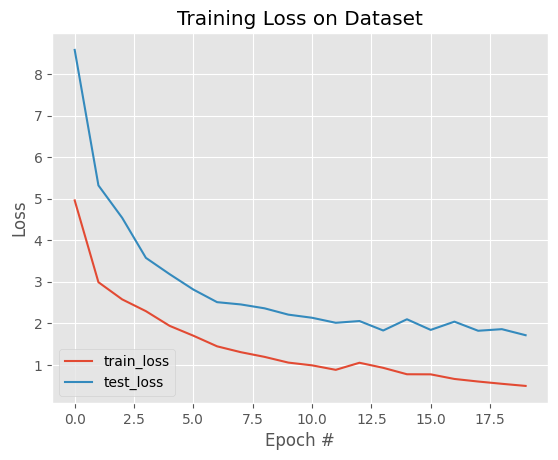

In [38]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

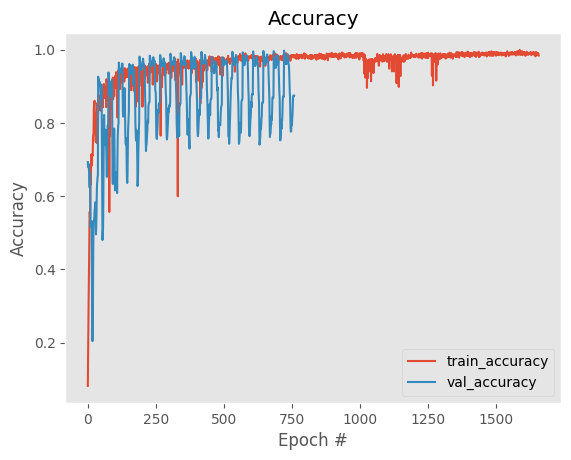

In [46]:
# Accuracy
plt.style.use("ggplot")
plt.figure()

train_accuracy = [x.cpu().numpy() for x in accuracy_dict["train"]]
val_accuracy = [x.cpu().numpy() for x in accuracy_dict["val"]]

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(val_accuracy, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()
plt.show()

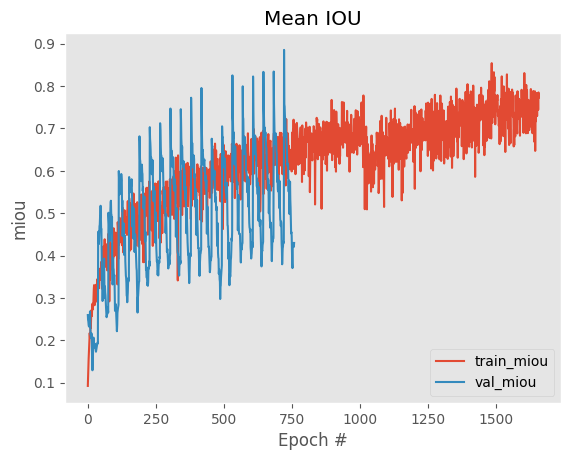

In [45]:
# Mean IoU
train_miou = [x.cpu().numpy() for x in miou_dict["train"]]
val_miou = [x.cpu().numpy() for x in miou_dict["val"]]

plt.plot(train_miou, label="train_miou")
plt.plot(val_miou, label="val_miou")
plt.title("Mean IOU")
plt.xlabel("Epoch #")
plt.ylabel("miou")
plt.legend(loc="lower right")
plt.grid()
plt.show()

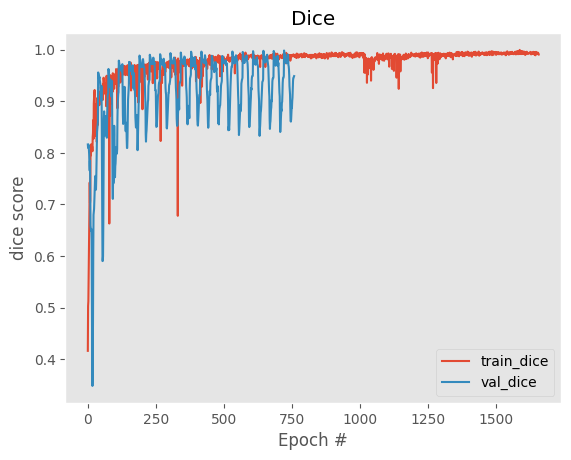

In [44]:
# Dice
train_dice = [x.cpu().numpy() for x in dice_dict["train"]]
val_dice = [x.cpu().numpy() for x in dice_dict["val"]]

plt.plot(train_dice, label="train_dice")
plt.plot(val_dice, label="val_dice")
plt.title("Dice")
plt.xlabel("Epoch #")
plt.ylabel("dice score")
plt.legend(loc="lower right")
plt.grid()
plt.show()